#Load and preprocess data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, StandardScaler

In [ ]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, MaxAbsScaler

train_data = np.genfromtxt('/content/gdrive/MyDrive/Manh Tuan/Experiments/Datasets/NSL-KDD/NSLKDD_Train.csv', dtype=np.float32, delimiter=',')
test_data  = np.genfromtxt('/content/gdrive/MyDrive/Manh Tuan/Experiments/Datasets/NSL-KDD/NSLKDD_Test.csv', dtype=np.float32, delimiter=',')
print(train_data.shape)
print(test_data.shape)

(125973, 123)
(22544, 123)


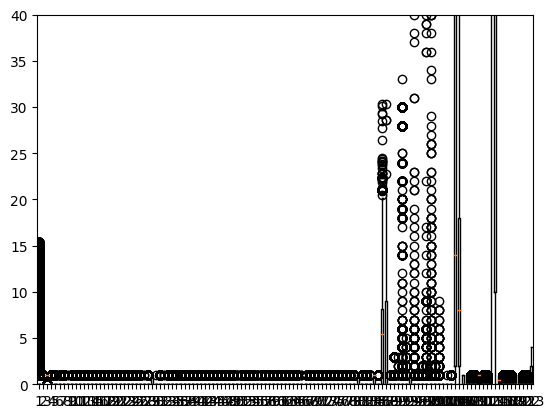

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(train_data)
# Set y-axis limits to zoom in
ax.set_ylim([0, 40])
# Show plot
plt.show()

Train: 67343 normal (0), 11656 Probe (1), 45927 DoS (2), 995 R2L (3), 52 U2R (4)

Test:  9711 normal (0),   2421 Probe (1),   7458  DoS (2), 2887 R2L (3), 67 U2R (4)

## Preprocess training data

Select the few shot attack type to detect

In [ ]:
#from sklearn.preprocessing import RobustScaler
scaler = StandardScaler()

#create training data with normal and attack type exclude U2R
train_data_not_u2r= train_data[(train_data[:, -1] != 4)]
#print(train_data_not_u2r.shape)
# With the train data, we Apply the pipeline to the data excluding the last column
#train_norm = pipeline.fit_transform(train_data_not_u2r[:,:-1])

train_norm = scaler.fit_transform(train_data_not_u2r[:,:-1])
# Create a new label based on the last column of the data, 0 to 1 and other to -1
new_label = np.where(train_data_not_u2r[:,-1] == 0, 1, -1)

# Append the new label to the transformed data
train_data_normalized = np.hstack((train_norm, new_label[:,np.newaxis]))
np.random.shuffle(train_data_normalized)
print("Train data shape: ", train_data_normalized.shape)
print("anomaly sample in train data: ", np.count_nonzero(train_data_normalized[:, -1] == -1))

Train data shape:  (125921, 123)
anomaly sample in train data:  58578


## Apply Scaler with testing data
- Apend few-shot attack type (U2R) from training data to testing data
- Select 200 normal and 20 U2R samples into supporting data
- Use the rest of testing data as querying data.

In [ ]:
#Append the U2R samples from training data into test data
u2r_from_train = train_data[train_data[:, -1]==4]
print (u2r_from_train.shape)
test_data_plus = np.vstack((test_data, u2r_from_train))
#test_data = np.concatenate((test_data, u2r_from_train), axis=0)
print("Test_data plus FS from train: ", test_data_plus.shape)
#Apply preprocessing with testdata
#test_norm = pipeline.transform(test_data[:,:-1])
test_norm = scaler.transform(test_data_plus[:,:-1])


#Append the label into the transformed test data
test_data_normalized_include_old_label = np.hstack((test_norm, test_data_plus[:,-1][:,np.newaxis]))

#We select  normal and U2R records only
test_data_fs = test_data_normalized_include_old_label[(test_data_normalized_include_old_label[:,-1] == 0) | (test_data_normalized_include_old_label[:,-1] == 4)]
np.random.shuffle(test_data_fs)
print("Test data with FS only shape: ", test_data_fs.shape)
print("anomaly samples in test data: ", np.count_nonzero(test_data_fs[:, -1] == 4))

(52, 123)
Test_data plus FS from train:  (22596, 123)
Test data with FS only shape:  (9830, 123)
anomaly samples in test data:  119


In [ ]:
# Create a new label based on the last column of the data, 0 (few shot) to -1, otherwise keep staying 1
labels_test = test_data_fs[:, -1]  # Extract the last column (labels)
labels_test[labels_test == 4] = -1  # Change all labels with value 4 to -1
labels_test[labels_test == 0] = 1  # Change all labels with value 0 to 1
test_data_fs[:, -1] = labels_test

print("total few shot samples: ", np.count_nonzero(test_data_fs[:] == -1))

x_test = test_data_fs

normal_samples = x_test[x_test[:, -1] == 1]
anomaly_samples = x_test[x_test[:, -1] == -1]

total few shot samples:  119


# Building Discriminative Autoencoder

## Creating Parameter

In [ ]:
# Training Parameters
learning_rate = 0.01
num_steps = 100
batch_size = 100
display_step = 10

np.random.shuffle(train_data_normalized)
n_input = train_data_normalized.shape[1]
print(n_input)

# Network Parameters
num_hidden_1 = 85 # 1st layer num features
num_hidden_2 = 49 # 2nd layer num features (the latent dim)
num_hidden_3 = 12 # 3nd layer num features (the latent dim)

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
# tf Graph input (only pictures)
X = tf.compat.v1.placeholder("float", [None, n_input])

123


In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)

weights_en = {
    'encoder_h1': tf.Variable(xavier_init([n_input-1, num_hidden_1])),
    'encoder_h2': tf.Variable(xavier_init([num_hidden_1, num_hidden_2])),
    'encoder_h3': tf.Variable(xavier_init([num_hidden_2, num_hidden_3]))
}

weights_de = {
    'decoder_h1': tf.transpose(a=weights_en['encoder_h3']),    #12-49
    'decoder_h2': tf.transpose(a=weights_en['encoder_h2']),    #49 - 85
    'decoder_h3': tf.transpose(a=weights_en['encoder_h1']),    #85 - 122
}

weights_cl = {
    'classifier_h1': tf.transpose(a=weights_en['encoder_h3']),    #dau ra encoder
    'classifier_h2': tf.transpose(a=weights_en['encoder_h2']),    #49 - 85
    'decoder_h3': tf.transpose(a=weights_en['encoder_h1']),    #85 - 122
}

biases = {
    'encoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'encoder_b2': tf.Variable(tf.zeros(shape=[num_hidden_2])),
    'encoder_b3': tf.Variable(tf.zeros(shape=[num_hidden_3])),

    'decoder_b1': tf.Variable(tf.zeros(shape=[num_hidden_2])),
    'decoder_b2': tf.Variable(tf.zeros(shape=[num_hidden_1])),
    'decoder_b3': tf.Variable(tf.zeros(shape=[n_input-1]))
}

In [ ]:
def label(x):
    return x[:, -1]

def encoder(x):
    #remove the label
    x = x[:, :-1]
    # Encoder Hidden layer with sigmoid activation
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights_en['encoder_h1']), biases['encoder_b1']))

    # Encoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights_en['encoder_h2']), biases['encoder_b2']))

    # Encoder Hidden layer with sigmoid activation
    layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights_en['encoder_h3']), biases['encoder_b3']))

    return layer_3



def decoder(x):
    # Decoder Hidden layer with sigmoid activation
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights_de['decoder_h1']), biases['decoder_b1']))

    # Decoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights_de['decoder_h2']), biases['decoder_b2']))

    layer_3 = tf.add(tf.matmul(layer_2, weights_de['decoder_h3']), biases['decoder_b3'])

    return layer_3


## Define loss function

In [ ]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
label_data = label(X)
alpha=1
# Prediction
y_pred = decoder_op
x_encoder=encoder_op
# Targets are the input data.
y_true = X[:, :-1]

# Define loss and optimizer, minimize the squared error
loss_distance = tf.reduce_mean(input_tensor=tf.abs(y_true - y_pred))
hidden_data = tf.reduce_mean(input_tensor=tf.abs(x_encoder))
#loss_distance = tf.reduce_mean(tf.pow(distance, label_data))
loss_hidden = tf.reduce_mean(tf.pow(hidden_data, tf.expand_dims(label_data, axis=1)))
loss = loss_distance + alpha*loss_hidden

#hidden_data = tf.reduce_mean(tf.pow(x_encoder, 2))
#loss = tf.reduce_mean(tf.pow(distance, label_data)) + tf.reduce_mean(tf.pow(hidden_data, tf.expand_dims(label_data, axis=1)))

optimizer = tf.compat.v1.train.AdadeltaOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.compat.v1.global_variables_initializer()

## Training Autoencoder

In [ ]:
# Training
# Pharse 1: Train for Auto Encoder Model
sess = tf.compat.v1.Session()

# Run the initializer
sess.run(init)

num_batch = int(train_data_normalized.shape[0]/batch_size)
# Training
for i in range(num_steps):
    # Prepare Data
    re = 0
    re_distance = 0
    re_hidden = 0
    for i_batch in range(num_batch):
        batch_x = train_data_normalized[i_batch*batch_size:(i_batch+1)*batch_size]
        _, re_batch, re_distance_batch, re_hidden_batch = sess.run([optimizer, loss, loss_distance, loss_hidden], feed_dict={X: batch_x})
        re += re_batch
        re_distance += re_distance_batch
        re_hidden += re_hidden_batch
        # Display logs per step
    if i % display_step == 0 or i == 1:
        z_train = sess.run(x_encoder,feed_dict={X:train_data_normalized})
        print('Step %3.0i: Total Loss: %0.4f, Distance Loss: %0.4f, Hidden Loss: %0.4f' % (i, re/num_batch, re_distance/num_batch, re_hidden/num_batch))
        #_,_,auc_ae    = AUC_AE(x_test, y_test)

Step   0: Total Loss: 1.6105, Distance Loss: 0.4711, Hidden Loss: 1.1393
Step   1: Total Loss: 1.4673, Distance Loss: 0.3953, Hidden Loss: 1.0721
Step  10: Total Loss: 1.1418, Distance Loss: 0.1380, Hidden Loss: 1.0038
Step  20: Total Loss: 1.1112, Distance Loss: 0.1120, Hidden Loss: 0.9992
Step  30: Total Loss: 1.1031, Distance Loss: 0.1049, Hidden Loss: 0.9982
Step  40: Total Loss: 1.0992, Distance Loss: 0.1012, Hidden Loss: 0.9979
Step  50: Total Loss: 1.0965, Distance Loss: 0.0988, Hidden Loss: 0.9977
Step  60: Total Loss: 1.0947, Distance Loss: 0.0971, Hidden Loss: 0.9976
Step  70: Total Loss: 1.0933, Distance Loss: 0.0957, Hidden Loss: 0.9976
Step  80: Total Loss: 1.0920, Distance Loss: 0.0945, Hidden Loss: 0.9976
Step  90: Total Loss: 1.0909, Distance Loss: 0.0933, Hidden Loss: 0.9976


## Visulize the latent data for training data

Text(0.5, 1.0, 'latent for training data NSL Loss 2')

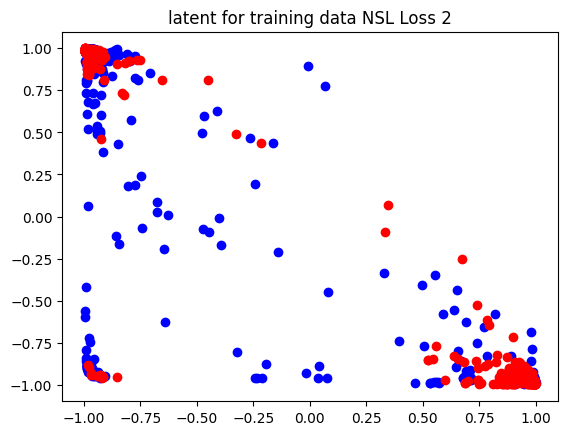

In [ ]:
#Lớp ẩn AE cho dữ liệu meta training
#Chon feature de visualize dữ liệu lớp ấn
f1 = 0
f2 = 6

#append z_train with its label
z_train_label = train_data_normalized[:, -1]
z_train_with_label = np.hstack((z_train, z_train_label[:,np.newaxis]))

z_train_normal_f = z_train_with_label[z_train_with_label[:,-1]== 1]
z_train_anomaly_f = z_train_with_label[z_train_with_label[:,-1]== -1]

#select random 1000 normal samples and 1000 anomaly samples in z_train
z_train_normal_rows = np.random.choice(z_train_normal_f.shape[0], size = 1000, replace = False)
z_train_anomaly_rows = np.random.choice(z_train_anomaly_f.shape[0], size = 1000, replace = False)
z_train_normal = z_train_normal_f[z_train_normal_rows]
z_train_anomaly = z_train_anomaly_f[z_train_anomaly_rows]


#Visualize latent data
plt.scatter(z_train_normal[:, f1], z_train_normal[:, f2], color = 'b')
plt.scatter(z_train_anomaly[:, f1], z_train_anomaly[:, f2], color = 'r')
plt.title('latent for training data NSL Loss 2')

Text(0.5, 1.0, 'latent for testing data NSL Loss 2')

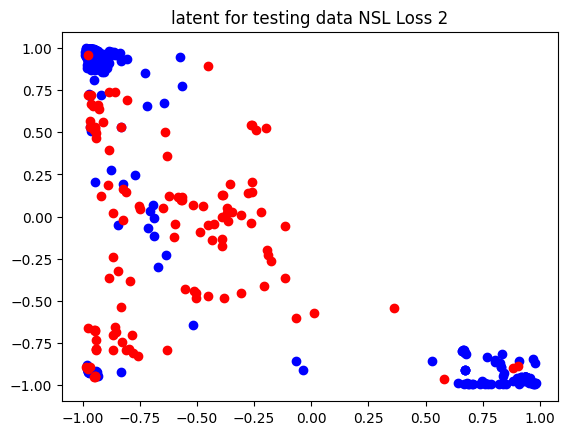

In [ ]:
#latent data of test data
z_test = sess.run(x_encoder, feed_dict={X:x_test})
#append z_test with its label
z_test_with_label = np.hstack((z_test, labels_test[:,np.newaxis]))

z_test_normal_f = z_test_with_label[z_test_with_label[:,-1]== 1]
z_test_anomaly = z_test_with_label[z_test_with_label[:,-1]== -1]

#select random 1000 normal samples and anomaly samples in z_train
z_test_normal_rows = np.random.choice(z_test_normal_f.shape[0], size = 1000, replace = False)
z_test_normal = z_test_normal_f[z_test_normal_rows]

#Visualize latent data
plt.scatter(z_test_normal[:, f1], z_test_normal[:, f2], color = 'b')
plt.scatter(z_test_anomaly[:, f1], z_test_anomaly[:, f2], color = 'r')
plt.title('latent for testing data NSL Loss 2')

# Meta testing phase

A batch contain selecting 10 normal and selecting 10 U2R samples from supporting data.



## Split testing data to support and query
- Select random 200 normal and 20 anomaly
- Get their latent data
- Remark its label

In [ ]:
def split_test(normal_samples, anomaly_samples):
  # Randomly select 200 normal samples and 20 anomaly samples as support data
  support_normal_indices = np.random.choice(np.arange(len(normal_samples)), size=200, replace=False)
  support_anomaly_indices = np.random.choice(np.arange(len(anomaly_samples)), size=20, replace=False)
  support_normal_samples = normal_samples[support_normal_indices]
  support_anomaly_samples = anomaly_samples[support_anomaly_indices]
  support_test = np.concatenate((support_normal_samples, support_anomaly_samples))

  # Select the rest of the samples as querying data
  querying_normal_indices = np.setdiff1d(np.arange(len(normal_samples)), support_normal_indices)
  querying_anomaly_indices = np.setdiff1d(np.arange(len(anomaly_samples)), support_anomaly_indices)
  querying_normal_samples = normal_samples[querying_normal_indices]
  querying_anomaly_samples = anomaly_samples[querying_anomaly_indices]
  query_test = np.concatenate((querying_normal_samples, querying_anomaly_samples), axis=0)

  # Shuffle the querying data
  np.random.shuffle(query_test)
  #print("Support data shape: ", support_test.shape)
  #print("Query data shape: ", query_test.shape)
  #print(query_test.shape)
  count_ps_support = np.count_nonzero(support_test[:, -1] == -1)
  #print("Anomaly samples for support: ", count_ps_support)
  count_ps_query = np.count_nonzero(query_test[:, -1] == -1)
  #print("Anomaly samples for query: ", count_ps_query)
  #Get the latent data of testing data
  z_data_support  = sess.run(x_encoder,feed_dict={X:support_test})
  z_data_query  = sess.run(x_encoder,feed_dict={X:query_test})

  #Remark label 0 , 1 toward test data to apply binary cross entropy
  label_support = support_test[:, -1]
  label_support[label_support == -1] = 0
  label_query = query_test[:, -1]
  label_query[label_query == -1] = 0

  z_support = np.hstack((z_data_support, label_support[:,np.newaxis]))
  z_query = np.hstack((z_data_query, label_query[:,np.newaxis]))

  return z_support, z_query, label_support, label_query, z_data_query

## Define the neural network model as classifier

In [ ]:
# Define input and output dimensions
input_dim = 12
output_dim = 1

# Define the model binary classifier

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=input_dim, activation='tanh', kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
    #tf.keras.layers.Dropout(0.3)
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Create batch for few shot training

In [ ]:
#Create data for training support


# Define batch size
#batch_size = 20
#num_epochs = 5
# Define number of batches per epoch
def create_batch(z_data, epoch):
  normal_z = z_data[z_data[:, -1]==1]
  anomaly_z = z_data[z_data[:, -1]==0]
  if normal_z.shape[0] > 0:
    normal_idx = np.random.choice(normal_z.shape[0], 10, replace=False)
  else:
    normal_idx = []
  #print("Index of normal batch: ", normal_idx)
  if anomaly_z.shape[0] > 0:
    anomaly_idx = np.random.choice(anomaly_z.shape[0], 10, replace=False)
  else:
    anomaly_idx = []
  '''
  if epoch % 2 == 1:
    anomaly_idx = np.arange(10)
  else:
    anomaly_idx = np.arange(10, 20)
  '''
  #print(anomaly_idx)
  #print(anomaly_z[anomaly_idx])

  #print(indices_anomaly)
  # Concatenate normal and anomaly samples to create batch
  batch = np.concatenate([normal_z[normal_idx], anomaly_z[anomaly_idx]], axis=0)
  np.random.shuffle(batch)

  return batch




## Train the classifier and print the result
For i in range 10:
- Get support data
- get fresh model
- for j in range 6: Get batch and run model with 10 epochs

In [ ]:
import statistics
from sklearn.metrics import roc_auc_score
import csv

auc_list = []
for i in range (10):
  z_support, z_query, label_support, label_query, z_data_query = split_test(normal_samples, anomaly_samples)
  loss_list = []
  accuracy_list = []
  val_loss_list = []
  val_acc_list = []

  # Create a new model instance with the same architecture
  new_model = tf.keras.models.clone_model(model)
  new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  for j in range(100):
    batch = create_batch(z_support, j)
    #print(batch.shape)

    support_x = batch[:, :-1]
    #print(support_x)
    support_y = batch[:, -1]
    #print(support_y)
    history = new_model.fit(support_x, support_y, epochs=1, batch_size=20,  \
                        validation_data=(z_data_query, label_query), verbose = 0)
    loss_values = history.history['loss']
    accuracy_values = history.history['accuracy']
    val_loss_values = history.history['val_loss']
    val_accuracy_values = history.history['val_accuracy']

    # Write the loss and accuracy values to a CSV file
    with open('/content/gdrive/MyDrive/Manh Tuan/Experiments/Edit1/loss_plot/nslkdd_loss2_many.csv', 'a', newline='') as csvfile:
      writer = csv.writer(csvfile)

      # Write header
      #writer.writerow(['Epoch', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy'])

      # Write data rows
      for epoch, loss, accuracy, val_loss, val_accuracy in zip(range(1, len(loss_values) + 1), loss_values, accuracy_values, val_loss_values, val_accuracy_values):
          writer.writerow([epoch, loss, accuracy, val_loss, val_accuracy])


  y_pred_prob = new_model.predict(z_data_query)
  y_pred_label = np.argmax(y_pred_prob)
  auc_score = roc_auc_score(label_query, y_pred_prob)
  auc_list.append(auc_score)
  print("Exp: ", i, "done: ", auc_score)
print("AUC mean: %0.4f" % statistics.mean(auc_list))


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  0 done:  0.9473708805009403


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  1 done:  0.9350852654395921


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  2 done:  0.8780221519155383


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  3 done:  0.9486272673108967


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  4 done:  0.913078848627161


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  5 done:  0.8779499335697422


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  6 done:  0.9526927353654301


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  7 done:  0.9523698768783408


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  8 done:  0.9422316955699356


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Exp:  9 done:  0.8967654677359229
AUC mean: 0.9244


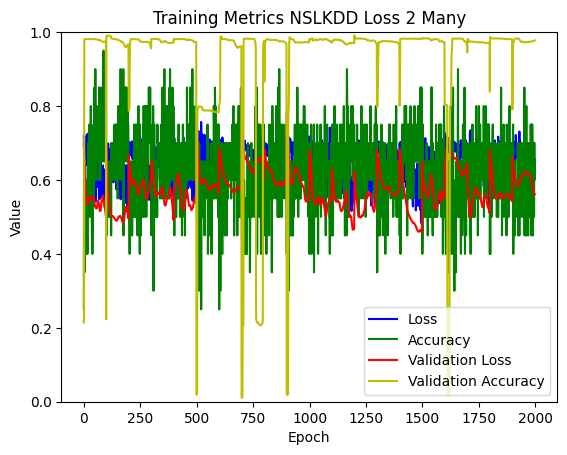

In [ ]:
# Plot line chart to choose right epochs:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('/content/gdrive/MyDrive/Manh Tuan/Experiments/Edit1/loss_plot/nslkdd_loss2_many.csv')

# Extract the values from the columns
loss = df.iloc[:, 1]
acc = df.iloc[:, 2]
loss_val = df.iloc[:, 3]
acc_val = df.iloc[:, 4]

# Create a line chart
plt.plot(loss, color = 'b', label='Loss')
plt.plot(acc, color = 'g', label='Accuracy')
plt.plot(loss_val, color = 'r', label='Validation Loss')
plt.plot(acc_val, color = 'y', label='Validation Accuracy')

# Set the y-axis limits to (0, 1)
plt.ylim(0, 1)

# Add labels and title to the chart
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics NSLKDD Loss 2 Many')

# Add a legend
plt.legend()

# Display the chart
plt.show()


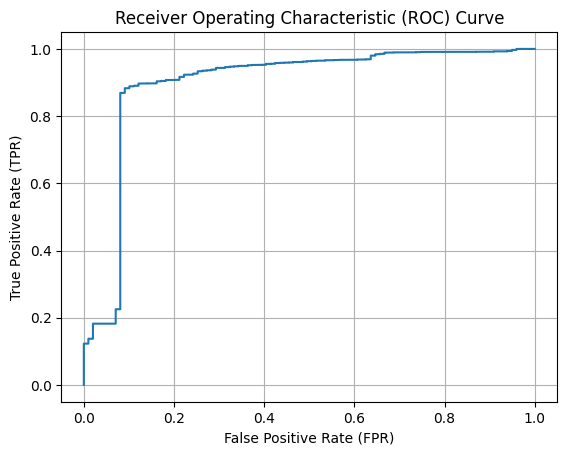

In [ ]:
y_pred_prob = new_model.predict(z_data_query)
y_pred_label = np.argmax(y_pred_prob)
auc_score = roc_auc_score(label_query, y_pred_prob)
fpr, tpr, thresholds = roc_curve(label_query, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True)
plt.show()


In [ ]:
# calculate the confusion matrix based on optimal threshold


# Compute the Euclidean distance from each point to (0.5, 0.5)
distances = np.sqrt((fpr - 0.5)**2 + (tpr - 0.5)**2)
print(type(distances))
# Find the maximum value of distance
optimal_threshold = np.max(distances)

# Use the optimal threshold to classify your data
predicted_labels = np.where(y_pred_prob >= 0.5, 1, 0)
print(predicted_labels)
confusion = confusion_matrix(label_query, predicted_labels)
tp = confusion[1][1]
fn = confusion[1][0]
fp = confusion[0][1]
tn = confusion[0][0]
detection_rate = tn*100 / (fp + tn)
accuracy = (tp+tn) / (tp+fp+fn+tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2 * (precision * recall) / (precision + recall)

<class 'numpy.ndarray'>
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [ ]:
print('AUC : %0.4f' % (auc_score))
print ('Detection rate: %0.4f'% (detection_rate))
print ('Accuracy: %0.4f ' % accuracy)
print ('Precision: %0.4f' % precision)
print ('Recall : %0.4f' % recall)
print ('F1_score: %0.4f'% f1_score)


AUC : 0.8968
Detection rate: 35.3535
Accuracy: 0.9775 
Precision: 0.9932
Recall : 0.9840
F1_score: 0.9886
